In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from sklearn.dummy import DummyRegressor

pd.set_option('display.max_rows', 100) # Allows Jupyter Notebook to expand how much data is shown.

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [3]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4580474287.770987,540296.573506,3.373200,2.115826,2080.321850,15099.408760,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2876735715.747780,367368.140101,0.926299,0.768984,918.106125,41412.636876,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1000102.000000,78000.000000,1.000000,0.500000,370.000000,520.000000,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2123049175.000000,322000.000000,3.000000,1.750000,1430.000000,5040.000000,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3904930410.000000,450000.000000,3.000000,2.250000,1910.000000,7618.000000,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7308900490.000000,645000.000000,4.000000,2.500000,2550.000000,10685.000000,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9900000190.000000,7700000.000000,33.000000,8.000000,13540.000000,1651359.000000,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


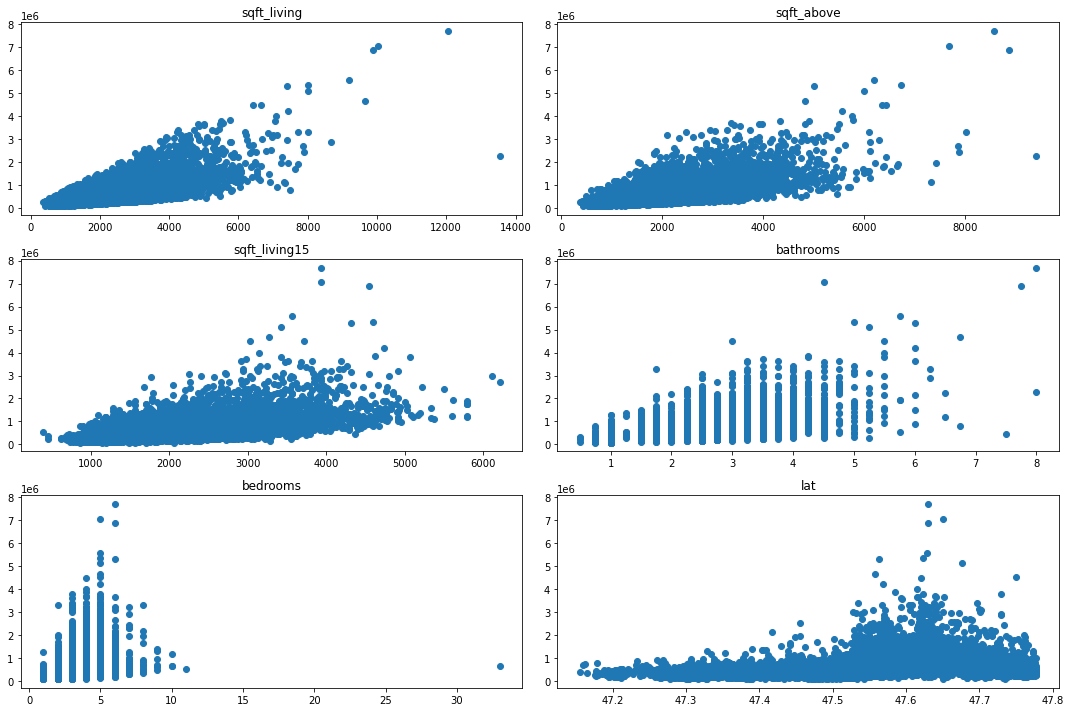

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(15,10))
axs[0, 0].scatter(df.sqft_living, df.price)
axs[0, 0].set_title('sqft_living')
axs[0, 1].scatter(df.sqft_above, df.price)
axs[0, 1].set_title('sqft_above')
axs[1, 0].scatter(df.sqft_living15, df.price)
axs[1, 0].set_title('sqft_living15')
axs[1, 1].scatter(df.bathrooms, df.price)
axs[1, 1].set_title('bathrooms')
axs[2, 0].scatter(df.bedrooms, df.price)
axs[2, 0].set_title('bedrooms')
axs[2, 1].scatter(df.lat, df.price)
axs[2, 1].set_title('lat')
fig.tight_layout();

In [5]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852


In [6]:
price_corr = df.corr()['price'].map(abs).sort_values(ascending=False)
price_corr

price            1.000000
sqft_living      0.701917
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
bedrooms         0.308787
lat              0.306692
floors           0.256804
yr_renovated     0.129599
sqft_lot         0.089876
sqft_lot15       0.082845
yr_built         0.053953
zipcode          0.053402
long             0.022036
id               0.016772
Name: price, dtype: float64

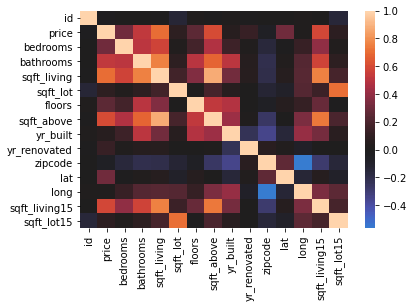

In [7]:
sns.heatmap(df.corr(),center=0);

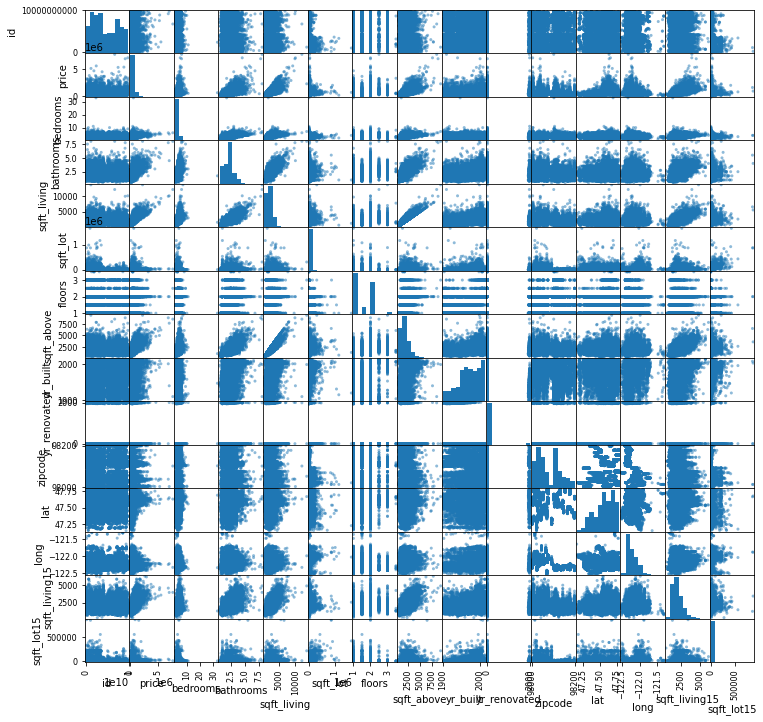

In [8]:
pd.plotting.scatter_matrix(df,figsize=(12,12));

# Data cleaning

In [9]:
def determine_dupes(series):
    series_vcs = pd.Series(series.value_counts())
    series_dupes = [series_vcs.index[index] for index in range(len(series_vcs)) if series_vcs.values[index] > 1]
    print("Amount of unique duplicates: " + str(len(series_dupes)))
    print("Total amount of duplicates: " + str(series_vcs.values[0:len(series_dupes)].sum()))
    
    return series_vcs

In [10]:
determine_dupes(df.id)

Amount of unique duplicates: 176
Total amount of duplicates: 353


795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [11]:
df = df.drop_duplicates(subset=['id'], keep='last')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21420 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21420 non-null  int64  
 1   date           21420 non-null  object 
 2   price          21420 non-null  float64
 3   bedrooms       21420 non-null  int64  
 4   bathrooms      21420 non-null  float64
 5   sqft_living    21420 non-null  int64  
 6   sqft_lot       21420 non-null  int64  
 7   floors         21420 non-null  float64
 8   waterfront     19067 non-null  object 
 9   view           21357 non-null  object 
 10  condition      21420 non-null  object 
 11  grade          21420 non-null  object 
 12  sqft_above     21420 non-null  int64  
 13  sqft_basement  21420 non-null  object 
 14  yr_built       21420 non-null  int64  
 15  yr_renovated   17607 non-null  float64
 16  zipcode        21420 non-null  int64  
 17  lat            21420 non-null  float64
 18  long  

In [12]:
df.drop(df.loc[df['bedrooms']==33].index, inplace=True)
df.drop(df.loc[df['bedrooms']==11].index, inplace=True)
df.drop(df.loc[df['bedrooms']==10].index, inplace=True)
df.drop(df.loc[df['bedrooms']==9].index, inplace=True)

df.sort_values('bedrooms', ascending=False).head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10946,1652500060,7/11/2014,1650000.0,8,2.75,4040,20666,1.0,NO,NONE,...,9 Better,2020,2020.0,1962,0.0,98004,47.6340,-122.221,3670,20500
12872,8813400155,12/19/2014,808000.0,8,3.75,3460,4600,2.0,NO,NONE,...,7 Average,2860,600.0,1987,0.0,98105,47.6617,-122.289,2170,3750
17221,1338600225,5/28/2014,1970000.0,8,3.50,4440,6480,2.0,NO,GOOD,...,10 Very Good,3140,1300.0,1959,0.0,98112,47.6310,-122.303,4440,8640
15656,8141200080,8/14/2014,680000.0,8,2.75,2530,4800,2.0,NO,NONE,...,7 Average,1390,1140.0,1901,NaN,98112,47.6241,-122.305,1540,4800
1658,9126101740,12/4/2014,490000.0,8,5.00,2800,2580,2.0,NO,NONE,...,8 Good,1880,920.0,1997,0.0,98122,47.6086,-122.303,1800,2580
9068,6746700615,3/18/2015,700000.0,8,2.50,2280,3000,1.5,NO,NONE,...,7 Average,1210,1070.0,1911,0.0,98105,47.6675,-122.316,1610,3000
4031,685000115,10/7/2014,2150000.0,8,6.00,4340,9415,2.0,NO,NONE,...,8 Good,4340,0.0,1967,0.0,98004,47.6316,-122.202,2050,9100
4063,7226500100,2/19/2015,373000.0,8,3.00,2850,12714,1.0,NaN,NONE,...,7 Average,2850,0.0,1959,0.0,98055,47.4859,-122.205,1480,4942
6168,1873400020,7/3/2014,340000.0,8,2.75,2790,6695,1.0,NaN,NONE,...,7 Average,1470,1320.0,1977,NaN,98133,47.7565,-122.331,1760,7624
19287,3756900027,11/25/2014,575000.0,8,3.00,3840,15990,1.0,NO,NONE,...,7 Average,2530,1310.0,1961,0.0,98034,47.7111,-122.211,1380,8172


In [13]:
df.yr_renovated = df.yr_renovated.fillna(0)
df.yr_renovated = df.yr_renovated.astype('int64')

df.view = df.view.fillna('NONE')

df.waterfront = df.waterfront.fillna('NO')

df.loc[df.sqft_basement == '?', 'sqft_basement'] = 0.0
df.sqft_basement = df.sqft_basement.astype('float64').astype('int64')

# df.grade = pd.to_numeric(df.grade.map(lambda x: x.split()[0]))

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21409 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21409 non-null  int64  
 1   date           21409 non-null  object 
 2   price          21409 non-null  float64
 3   bedrooms       21409 non-null  int64  
 4   bathrooms      21409 non-null  float64
 5   sqft_living    21409 non-null  int64  
 6   sqft_lot       21409 non-null  int64  
 7   floors         21409 non-null  float64
 8   waterfront     21409 non-null  object 
 9   view           21409 non-null  object 
 10  condition      21409 non-null  object 
 11  grade          21409 non-null  object 
 12  sqft_above     21409 non-null  int64  
 13  sqft_basement  21409 non-null  int64  
 14  yr_built       21409 non-null  int64  
 15  yr_renovated   21409 non-null  int64  
 16  zipcode        21409 non-null  int64  
 17  lat            21409 non-null  float64
 18  long  

# Looking at distributions

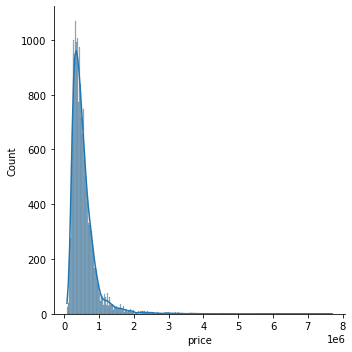

In [15]:
sns.displot(df['price'],kde=True);

As we can see the distribution of price is not normal.

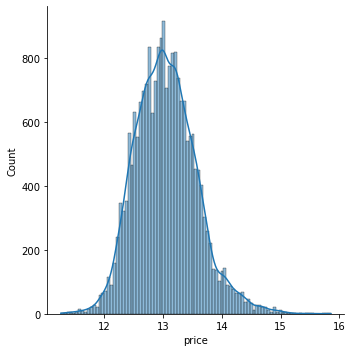

In [16]:
sns.displot(df['price'].apply(lambda x: np.log(x)),kde=True);

Applying a log transformation to the price column will make the distribution normal.

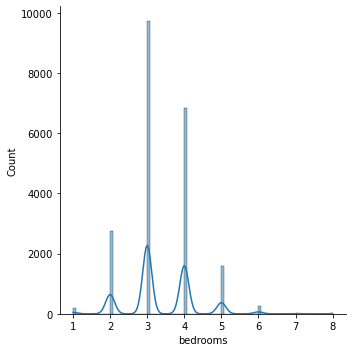

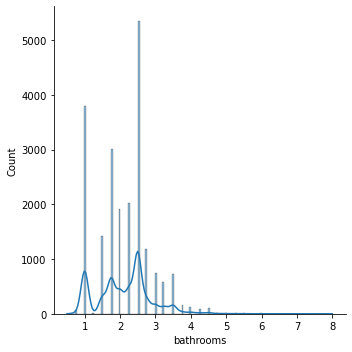

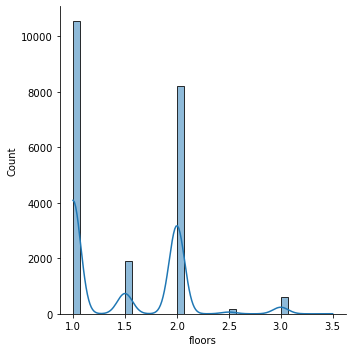

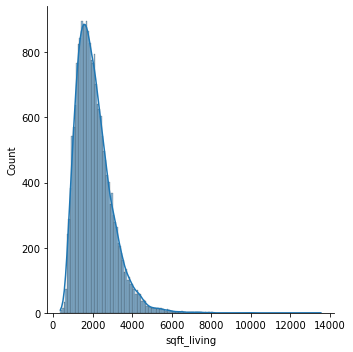

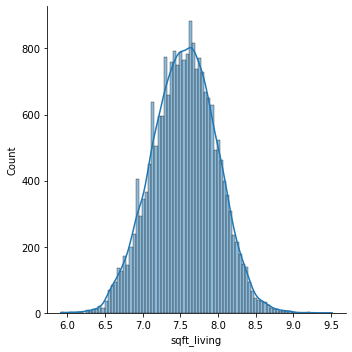

In [17]:
sns.displot(df['bedrooms'],kde=True)
sns.displot(df['bathrooms'],kde=True)
sns.displot(df['floors'],kde=True)
sns.displot(df['sqft_living'],kde=True)
sns.displot(df['sqft_living'].apply(lambda x: np.log(x)),kde=True);

# Trying a model

In [18]:
feature_cols = ['bedrooms', 'bathrooms','floors','sqft_living']
features = df[feature_cols]
target = df['price']

In [19]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features, target)
dummy_regr.score(features,target)

0.0

In [20]:
features = sm.add_constant(features)
model = sm.OLS(target,features).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     5513.
Date:                Tue, 16 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:34:38   Log-Likelihood:            -2.9714e+05
No. Observations:               21409   AIC:                         5.943e+05
Df Residuals:                   21404   BIC:                         5.943e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.053e+04   7931.807     11.414      0.000     7.5e+04    1.06e+05
bedrooms    -6.464e+04   2498.185    -25.876      0.000   -6.95e+04   -5.97e+04
bathrooms    9435.6432   3861.027      2.444      0.015    1867.742     1.7e+04
floors      -1032.7364   3799.527     -0.272      0.786   -8480.093    6414.620
sqft_living   312.4177      3.133     99.719      0.000     306.277     318.559
==============================================================================
Omnibus:                    14201.430   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           478450.498
Skew:                           2.712   Prob(JB):                         0.00
Kurtosis:                      25.515   Cond. No.                     1.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Floors has a large p-value which makes this feature not significant for this model.

# Mapping Houses

In [21]:
import folium

Create a sample of houses to mark on the map. Since they are many houses in the original df, marking all of them will be very hard to load. Just making sure the marking works.

In [22]:
sample = df.sample(20,random_state=33)

In [23]:
mp = folium.Map(location=[sample.lat.mean(),
                          sample.long.mean()], zoom_start=10, control_scale=True)
mp

In [24]:
for index, location_info in sample.iterrows():
    folium.Marker([location_info["lat"], location_info["long"]],
                  popup="$" + str(location_info["price"])).add_to(mp)

In [25]:
mp